In [9]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [10]:
# get wordfreq quantile
with open('simu4_data/simu4_word_freq.pkl', 'rb') as inp:
    df = pickle.load(inp)
df

,item,itemno_old,itemno,freq,quantile
0,ABDOMEN,1,1,110,2
1,ACROBAT,4,2,17,0
2,ADULT,8,3,906,8
3,ALLEY,15,4,165,3
4,ALLIGATOR,16,5,12,0
...,...,...,...,...,...
979,YOKE,1632,980,12,0
980,YOLK,1633,981,47,1
981,YOUTH,1634,982,1159,8
982,ZIPPER,1636,983,24,0


In [11]:
# s_mat = np.load('../Data/simu4_smat_lsa.npy')
s_mat = np.load('simu4_data/simu4_smat.npy')

In [12]:
# freq_order = df.sort_values(by="freq")['itemno'].to_numpy()

# n = len(df)
# smat_order = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         a = s_mat[freq_order[i],freq_order[j]]
#         if not np.isnan(a):
#             smat_order[i,j] = a
#         else:
#             smat_order[i,j] = 0

# smat_order

# plt.subplots(figsize=(20,20))
# sns.heatmap(smat_order,vmax = 0.5, vmin = 0, cmap = 'Reds')
# plt.xlabel('freq order')
# plt.ylabel('freq order')
# plt.title("association matrix of words in freq order")
# # plt.savefig('fig/simu4_smat.pdf')
# plt.show()

# df.groupby("quantile").count()

# np.mean(smat_order[:,0:100])

# np.mean(smat_order[:,-100:-1])

In [13]:
s_mat_dia = s_mat.copy()
np.fill_diagonal(s_mat_dia, 0)
df["s_mean"] = np.mean(s_mat_dia,axis=1)
df["log_freq"] = np.log(df["freq"])
df

,item,itemno_old,itemno,freq,quantile,s_mean,log_freq
0,ABDOMEN,1,1,110,2,0.120583,4.700480
1,ACROBAT,4,2,17,0,0.077693,2.833213
2,ADULT,8,3,906,8,0.089693,6.809039
3,ALLEY,15,4,165,3,0.115357,5.105946
4,ALLIGATOR,16,5,12,0,0.147916,2.484907
...,...,...,...,...,...,...,...
979,YOKE,1632,980,12,0,0.104083,2.484907
980,YOLK,1633,981,47,1,0.139488,3.850148
981,YOUTH,1634,982,1159,8,0.068605,7.055313
982,ZIPPER,1636,983,24,0,0.131708,3.178054


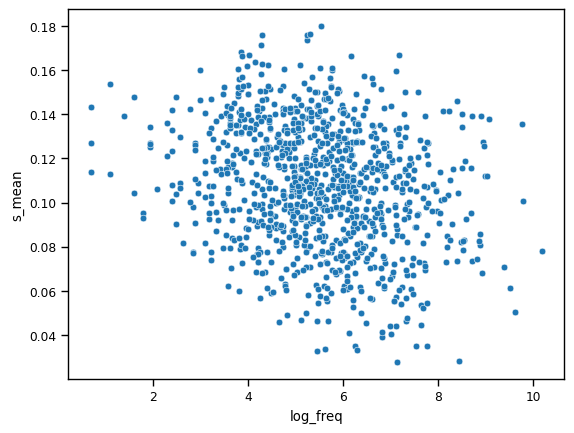

In [14]:
sns.scatterplot(data=df, x='log_freq', y='s_mean')
plt.savefig('simu4_fig/simu4_freq_sem.pdf')
plt.show()

In [15]:
model1 = smf.ols(formula='log_freq ~ s_mean', data=df).fit() 
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               log_freq   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     61.16
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.35e-14
Time:                        00:00:52   Log-Likelihood:                -1755.2
No. Observations:                 984   AIC:                             3514.
Df Residuals:                     982   BIC:                             3524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8657      0.182     37.787      0.0

In [16]:
# model-predicted word freq

with open("simu4_data/simu4_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)

params = cmr.make_default_params()
params.update(
    beta_enc = 0.4,
    beta_rec = 0.1,
    beta_rec_post = 0.2,
    gamma_fc = 0.1,
    s_fc = 0,
    c_thresh = 0.18,
    a = 2800,
    b = 2.14,
    m = 0,
    n = 1,
)

df_thin = df_test[['session','itemno']]
df_thin = df_thin.assign(s_resp=np.nan, s_rt=np.nan, csim=np.nan)

# extarct the session data
sess = 0
pres_mat = df_study.loc[df_study.session==sess,'itemno'].to_numpy()
pres_mat = np.reshape(pres_mat,(1, len(pres_mat)))
cue_mat = df_thin.loc[df_thin.session==sess,'itemno'].to_numpy()
sem_mat = s_mat

model = cmr.CMR2(params, pres_mat, sem_mat, source_mat=None,
           rec_mat=None, ffr_mat=None, cue_mat=cue_mat, task='Recog', mode='Final')

In [17]:
df['cal_word_freq'] = model.cal_word_freq
df

,item,itemno_old,itemno,freq,quantile,s_mean,log_freq,cal_word_freq
0,ABDOMEN,1,1,110,2,0.120583,4.700480,202.549667
1,ACROBAT,4,2,17,0,0.077693,2.833213,350.499329
2,ADULT,8,3,906,8,0.089693,6.809039,300.642303
3,ALLEY,15,4,165,3,0.115357,5.105946,216.544220
4,ALLIGATOR,16,5,12,0,0.147916,2.484907,142.809921
...,...,...,...,...,...,...,...,...
979,YOKE,1632,980,12,0,0.104083,2.484907,250.119720
980,YOLK,1633,981,47,1,0.139488,3.850148,159.057434
981,YOUTH,1634,982,1159,8,0.068605,7.055313,393.682587
982,ZIPPER,1636,983,24,0,0.131708,3.178054,175.692947


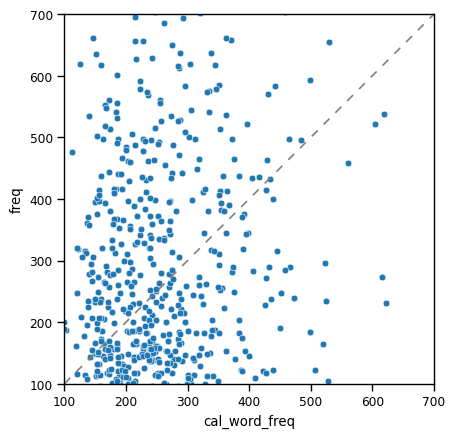

In [18]:
sns.scatterplot(data=df, x='cal_word_freq', y='freq')
plt.axis('square')
plt.ylim([100,700])
plt.xlim([100,700])
plt.axline((0, 0), slope=1, color="grey", linestyle=(0, (5, 5)))
# plt.savefig('fig/simu4_predfreq.pdf')
plt.show()